# In this notebook: 
- ways to zoom in on zones of milan, neighborhoods, and custom regions within given distance from a center

# Road network of Milan

In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import xyzservices.providers as xyz
#cx.providers for list of providers

In [ ]:
vehicle_path = "C:/Users/rickb/Documents/scuola/THESIS/datasets/Milan/DBT_2020/SHAPE/AC_VEI_AC_VEI_SUP_SR.shp"
gdf = gpd.read_file(vehicle_path)
gdf = gdf.drop(['AC_VEI_FON', 'AC_VEI_LIV', 'AC_VEI_SED', 'SUBREGID', 'CLASSREF'],axis = 1)

In [6]:
pattern = '01' # portions of road (e.g not intersections or parking lots) start with 01 in AC_VEI_ZON
gdf_roads = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern)]
pattern2 = ('01','0206','0204')
pattern3 = ('0206')
pattern4 = ('0204')
gdf_roads_piaz = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern2)]
gdf_round = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern3)]
gdf_piaz = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern4)]

## Areas and perimeters of streets

NB for the moment we're excluding tangenziali because some of the blocks are very large and make visualization difficult

In [7]:
gdf_roads_piaz = gdf_roads_piaz[~gdf_roads_piaz['NOME'].str.contains('TANGENZIALE', regex = False)] #removing tangenziali
gdf_roads = gdf_roads[~gdf_roads['NOME'].str.contains('TANGENZIALE', regex = False)]

In [8]:
OSM_crs = 3857
gdf_roads = gdf_roads.to_crs(epsg=OSM_crs)
gdf_roads_piaz = gdf_roads_piaz.to_crs(epsg=OSM_crs)
gdf_round = gdf_round.to_crs(epsg=OSM_crs)
gdf_piaz = gdf_piaz.to_crs(epsg=OSM_crs)

In [ ]:
gdf_roads['Perimeter'] = gdf_roads.length
gdf_round['Perimeter'] = gdf_round.length
gdf_piaz['Perimeter'] = gdf_piaz.length
gdf_roads_piaz['Perimeter'] = gdf_roads_piaz.length

gdf_roads['Area'] = gdf_roads.area
gdf_round['Area'] = gdf_round.area
gdf_piaz['Area'] = gdf_piaz.area
gdf_roads_piaz['Area'] = gdf_roads_piaz.area

### Average width calculation: 
Area is length times width for rectangles
Perimeter is 2(length) + 2(width)
$A = lw$
$P = 2l+2w$
brings us to solve for width as   

$P = 2\frac{A}{w}+2w$ 
so  
$w^2 -\frac{P}{2}w+A = 0$

In [ ]:
gdf_roads_piaz['temp'] = gdf_roads_piaz.Area/gdf_roads_piaz.Area # create column of ones

gdf_roads_piaz['SemiPeri'] = -gdf_roads_piaz.Perimeter/2 # i need it negative for the equation

In [14]:
def calculate_roots(row):
    coefficients = row[['temp', 'SemiPeri', 'Area']].values
    roots = np.roots(coefficients).real
    return roots

In [ ]:
#gdf_roads_piaz['roots'] = gdf_roads_piaz.apply(calculate_roots, axis=1)
gdf_roads_piaz['roots'] = gdf_roads_piaz[['temp', 'SemiPeri', 'Area']].apply(calculate_roots, axis=1)
gdf_roads_piaz[['root1', 'root2']] = pd.DataFrame(gdf_roads_piaz['roots'].tolist(), index=gdf_roads_piaz.index)
gdf_roads_piaz['width'] = gdf_roads_piaz['root2']
gdf_roads_piaz = gdf_roads_piaz.drop(['Perimeter', 'Area', 'temp', 'SemiPeri', 'roots', 'root1', 'root2'], axis = 1)


## dividing by zones with sjoin
let's try and get a better division into zones, to have more in depth plots.
We'll use another dataset which contains shapefiles of the main zones of Milan.

In [47]:
administrative_path = "C:/Users/rickb/Documents/scuola/THESIS/datasets/Milan/DBT_2020_new/DBT 2020 - SHAPE/Municipi.shp"
gdf2 = gpd.read_file(administrative_path)


In [48]:
gdf2.head()

,MUNICIPIO,AREA,PERIMETRO,geometry
0,1,9.426872e+06,11935.5825,"POLYGON ((515194.504 5036236.689, 515289.978 5..."
1,8,2.390648e+07,32807.3751,"POLYGON ((507753.424 5041976.551, 507756.349 5..."
2,9,2.101349e+07,27157.1251,"POLYGON ((513719.834 5042466.810, 513721.560 5..."
3,2,1.262855e+07,20971.2966,"POLYGON ((517487.727 5041139.616, 517489.529 5..."
4,3,1.443424e+07,25665.7875,"POLYGON ((520992.043 5039681.182, 520992.913 5..."


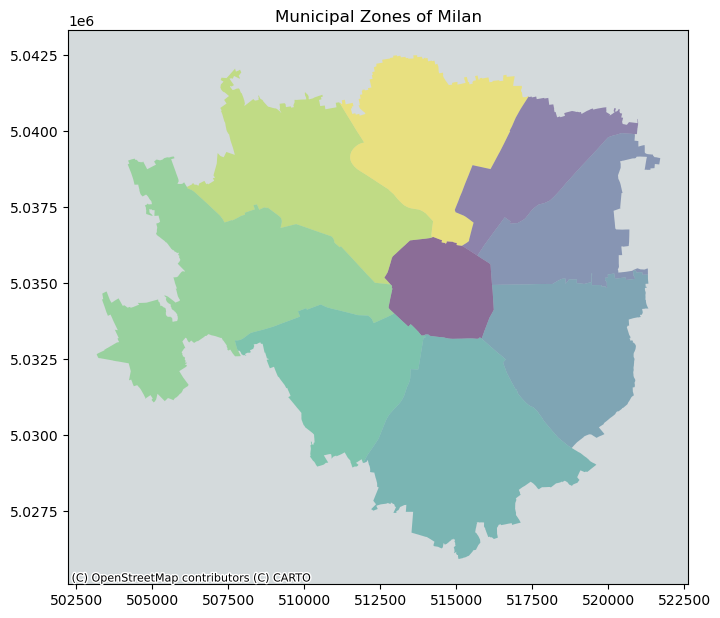

In [49]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
gdf2.plot(ax = ax, alpha = 0.5, column = 'MUNICIPIO' )
ax.set_title('Municipal Zones of Milan')
gdf2 = gdf2.to_crs(epsg = OSM_crs)
cx.add_basemap(ax, crs=gdf2.crs, zoom = 12, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite
#source=cx.providers.CartoDB.Positron)


Now we can use geopandas sjoin to perform a special join (in this case based on geometries) of our two dataframes

In [22]:
from geopandas.tools import sjoin

In [24]:
gdf_zone = gdf_roads_piaz.sjoin(gdf2, how = 'inner',predicate = 'intersects') # requires gpd > 0.9
#gdf_zone = gpd.sjoin(gdf_roads_piaz, gdf2, how = 'inner', op = 'intersects')
gdf_zone = gdf_zone.drop(['AREA', 'PERIMETRO', 'index_right'], axis =1)

As an example, we can see what the center of Milan looks like (Municipio 1)

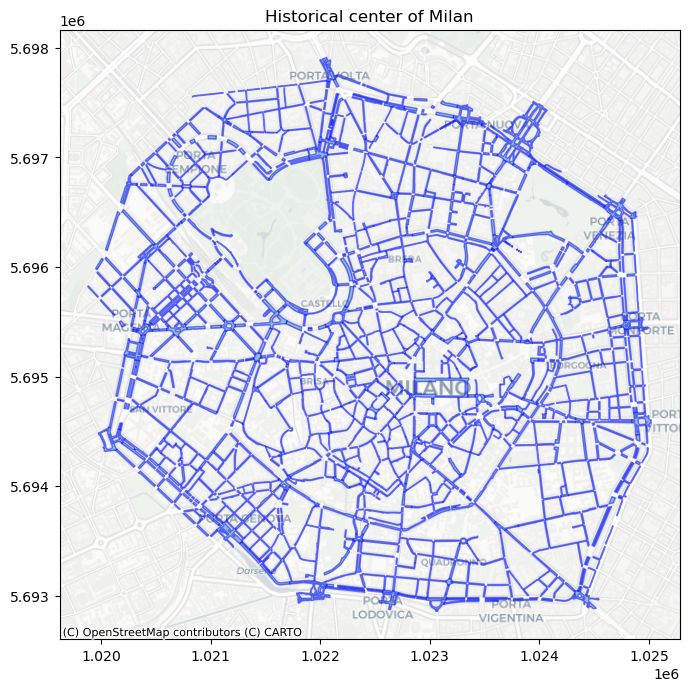

In [45]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_title('Historical center of Milan')
gdf_zone = gdf_zone.to_crs(epsg = OSM_crs)
gdf_zone[gdf_zone['MUNICIPIO'] == 1].plot(ax = ax, alpha=0.5, edgecolor="blue")
cx.add_basemap(ax, crs=gdf2.crs, zoom = 14, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite


We can go even further and divide based on neighborhoods. The procedure is the same, we just use a different dataset.

In [ ]:
neighborhood_path = "C:/Users/rickb/Documents/scuola/THESIS/datasets/Milan/Quartieri milano_real/NIL_WM.shp"
gdf_N = gpd.read_file(neighborhood_path)
gdf_N = gdf_N.to_crs(epsg = OSM_crs)
gdf_N = gdf_N.drop(['Valido_dal', 'Fonte', 'Shape_Leng', 'Shape_Area', 'OBJECTID', 'Valido_al'] ,axis=1)
#add neighborhoods to main dataset
gdf = gdf_zone.sjoin(gdf_N, how = 'inner',predicate = 'intersects')
gdf = gdf.drop(['index_right'], axis = 1)

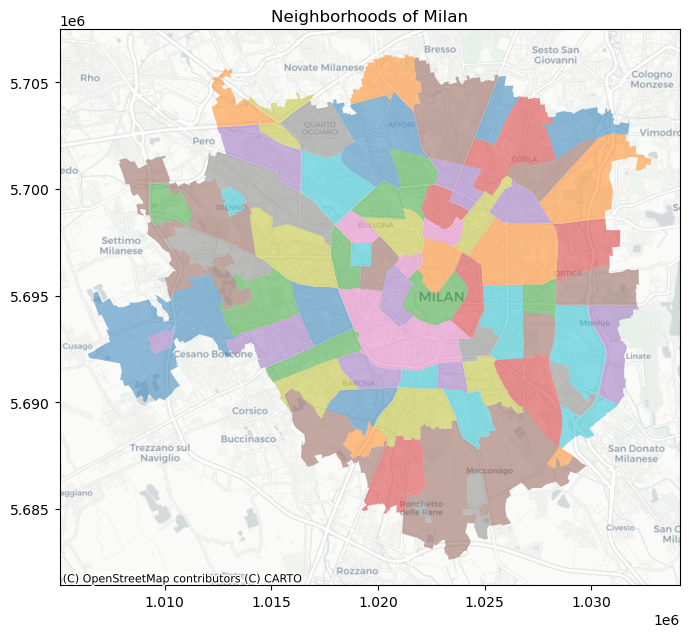

In [44]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
gdf_N.plot(ax = ax, alpha = 0.5, column = 'NIL' )
ax.set_title('Neighborhoods of Milan')
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 12, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite
#source=cx.providers.CartoDB.Positron)


As an example, let's plot my neighborhood in Milan

In [40]:
gdf_Stadera = gdf[gdf['NIL'] == 'STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA FALLATA']


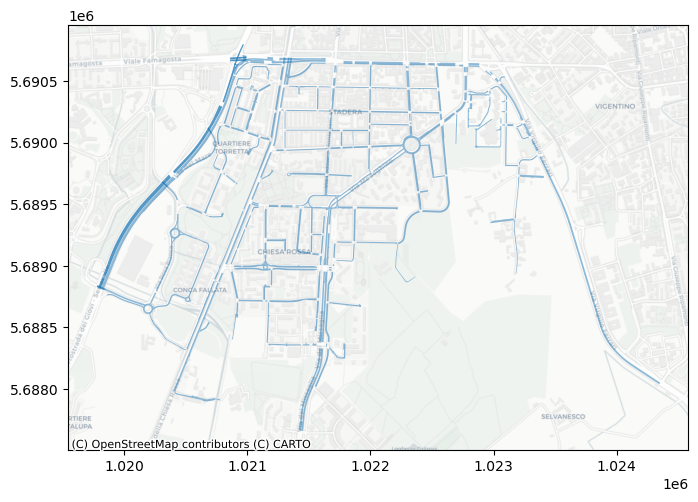

In [41]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
gdf_Stadera.plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 15, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite
#source=cx.providers.CartoDB.Positron)


To see which neighborhoods there are (and plot them by name) you can use the 
gdf.NIL.unique()
command.

## Creating custom ranges by distance

Here's a function to create a Geodataframe with all roads within a given distance from the road given as input

In [34]:
def within_dist(street, dist, gdf):
    #function creates gdf with all streets within distance dist (in meters) of street
    #street is a geodataframe, dist is a positive number, and gdf is the geodataframe dataset.
    temp = street.copy()
    temp.geometry = temp.geometry.buffer(dist)
    temp = temp.filter(['geometry']) #so sjoin doesn't give suffixes and i don't have to rename later
    gdf_distanced = gdf.sjoin(temp, how='inner', predicate='intersects')
    gdf_distanced = gdf_distanced.dropna()
    gdf_distanced = gdf_distanced.drop_duplicates(subset=['width'], keep='first') #removes streets within 2 buffers of a polygon
    gdf_distanced = gdf_distanced.iloc[:,:-1] #drops index_R column
    gdf_distanced.rename
    return gdf_distanced

To use it, first create a geodataframe of a single given street. This will be one of the inputs of the function.
e.g:

In [35]:
gdf_Volv = gdf[gdf['NOME'] == 'VIA VOLVINIO']

Now let's call the function with a distance of M meters

In [37]:
M = 100
gdf_test = within_dist(gdf_Volv, M, gdf)


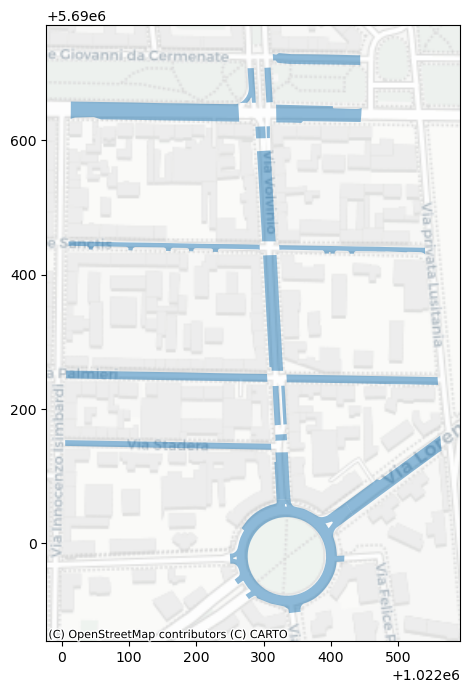

In [38]:
fig, ax = plt.subplots(1,1, figsize = (8,8))

gdf_test.plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 16, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite


Let's try to plot roads with color coding by width

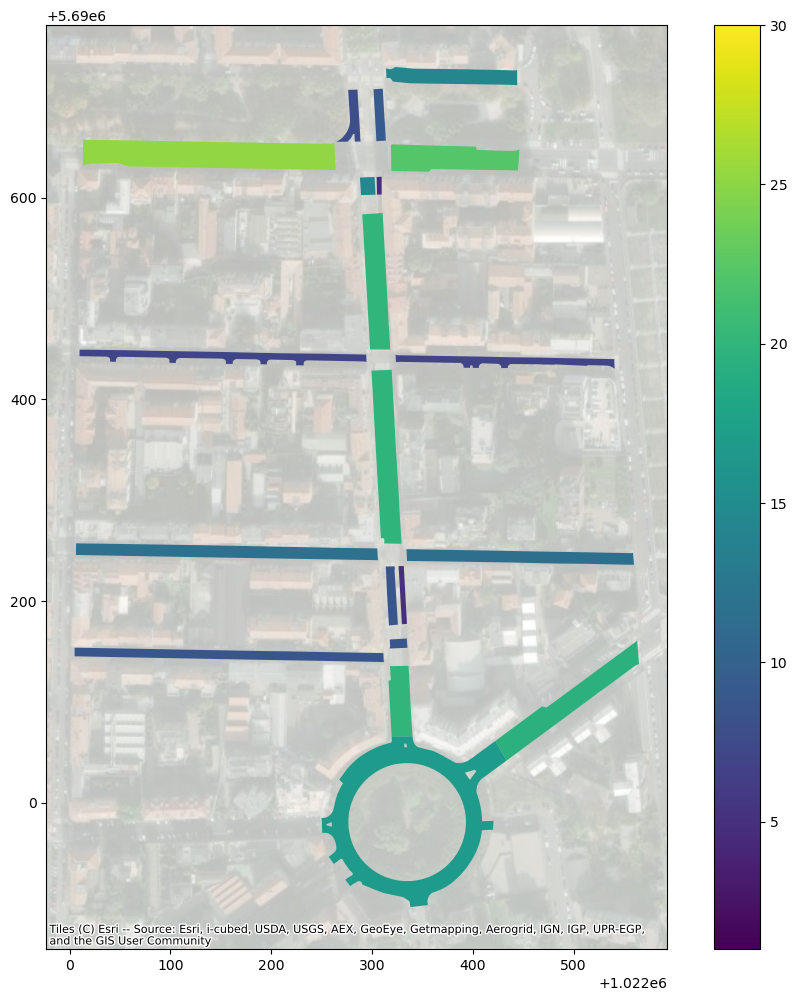

In [39]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf_test.plot(ax = ax, cmap = 'viridis', column = 'width', legend = True, vmin = 1, vmax = 30 )
cx.add_basemap(ax, crs=gdf_test.crs, source=cx.providers.Esri.WorldImagery, alpha =0.3) #providers.Esri.WorldImagery for satellite
plt.show()

Finally, we can set different thresholds to see networks of streets > width


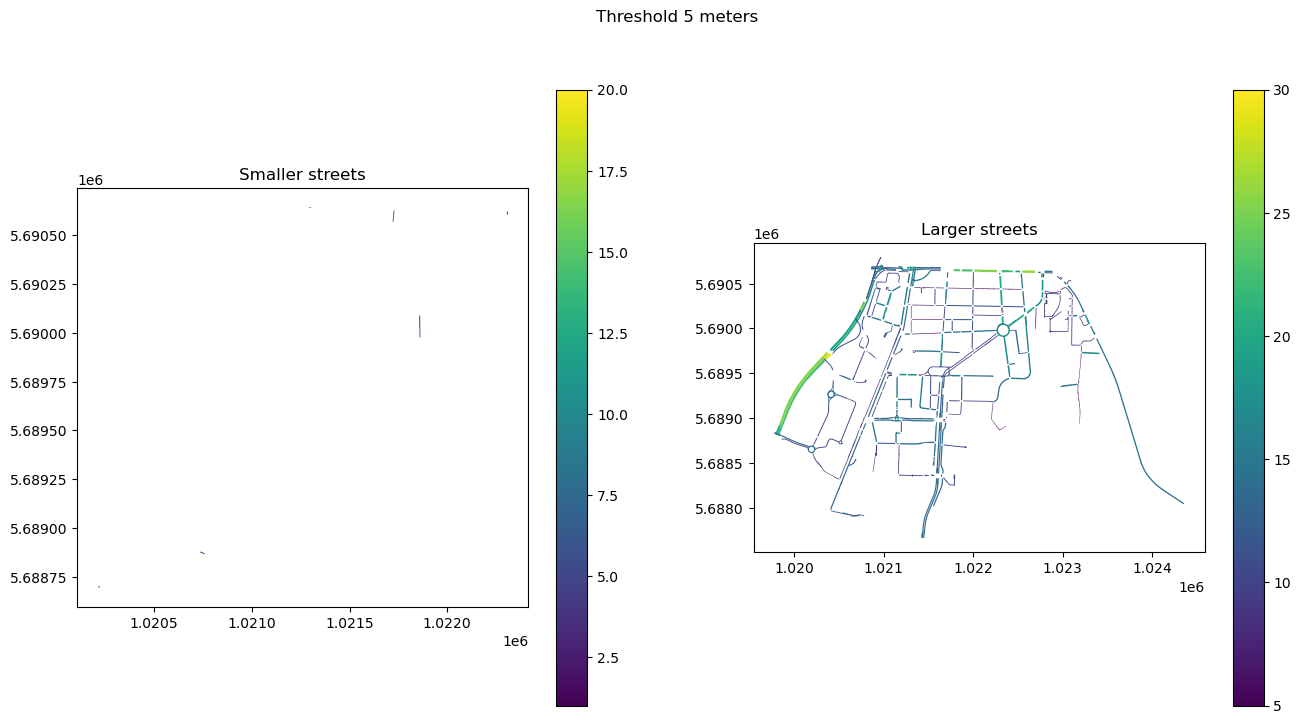

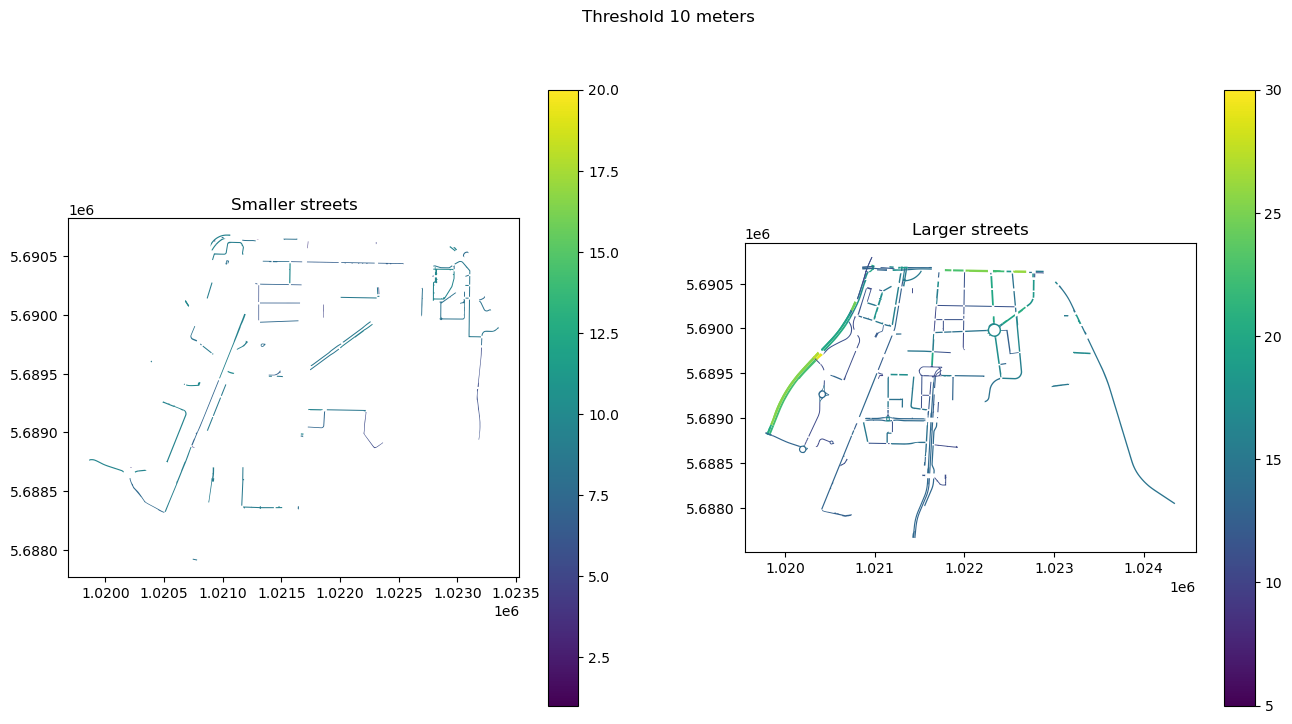

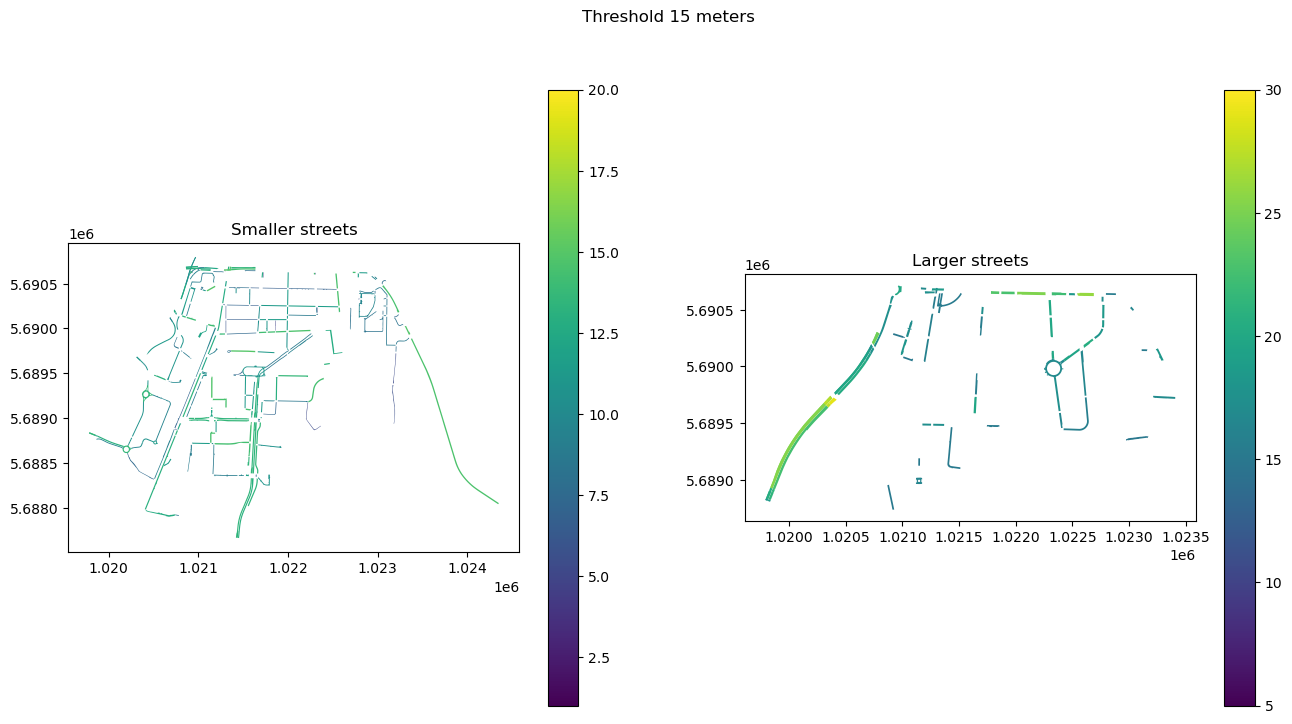

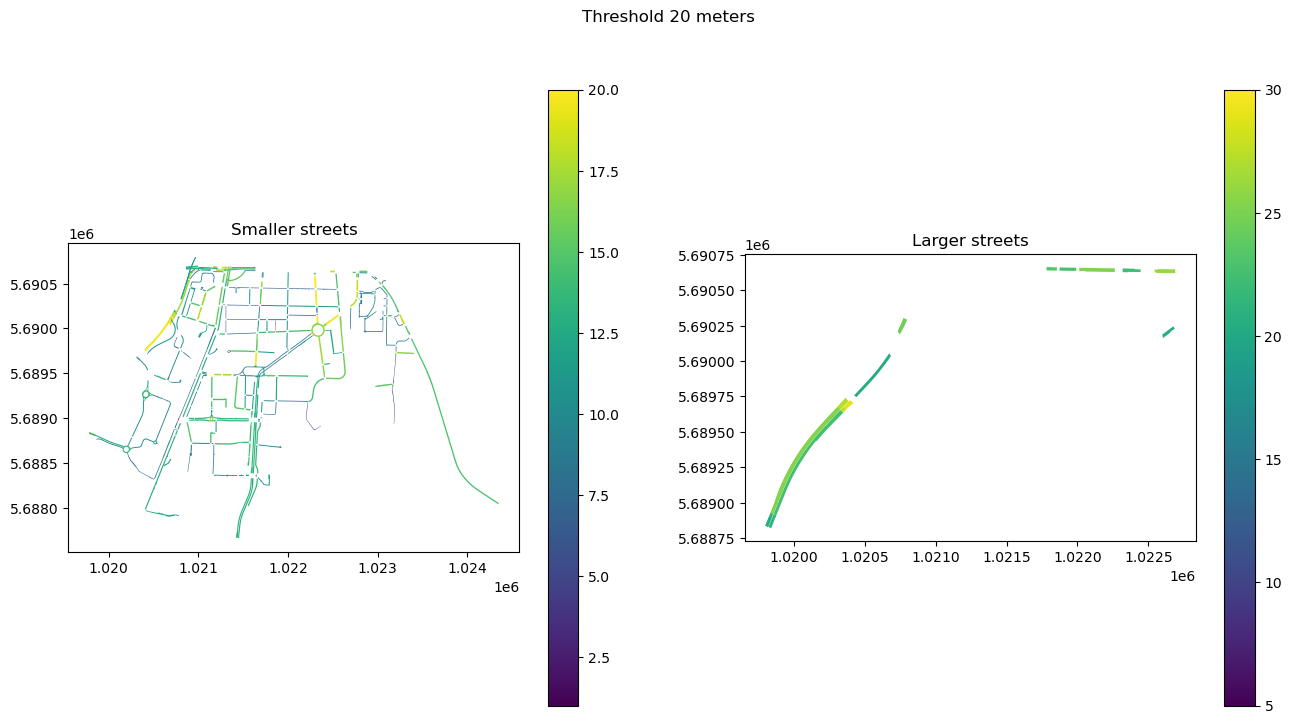

In [43]:
for split in [5, 10, 15, 20]:
    fig, axes = plt.subplots(1,2, figsize=(16,8))
    gdf1 = gdf_Stadera[gdf_Stadera['width'] <= split]
    gdf2 = gdf_Stadera[gdf_Stadera['width'] > split]
    ax = axes[0]
    gdf1.plot(ax = ax, cmap = 'viridis',column = 'width', legend = True, vmin = 1, vmax = 20 )
    ax.set_title('Smaller streets')
    ax = axes[1]
    gdf2.plot(ax = ax, cmap = 'viridis',column = 'width', legend = True, vmin = 5, vmax = 30 )
    # cx.add_basemap(ax, crs=gdf2.crs, source=cx.providers.Esri.WorldImagery, alpha =0.3) #providers.Esri.WorldImagery for satellite
    ax.set_title('Larger streets')
    fig.suptitle('Threshold ' + repr(split) + ' meters')
    plt.show()